In [1]:
import cmdstanpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

In [2]:
# Create the data 
np.random.seed(11)
N = 100
x = np.random.uniform(0, 1, size=N)
y0 = 1 + x + 4 * x**2 + np.sin(x * 3) * 3
ey = x * 0 + 0.3
y = y0 + np.random.normal(size=N) * ey

<ErrorbarContainer object of 3 artists>

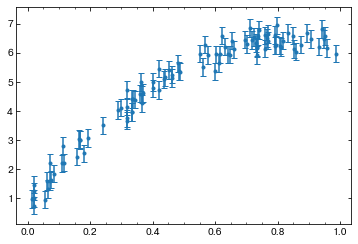

In [3]:
plt.errorbar(x,y,ey,fmt='.')

In [4]:
# Define the knots
xknots = np.array([0, 0.2, 0.4, 0.7, .9, 1])
nknots = len(xknots)

In [5]:
# contents of our stan model
# PLEASE make sure that you copy the spline.stan file in this directory!!!
!cat example.stan

#include spline.stan

data{
	int N;
	int nknots;
	vector[N] x;
	vector[N] y;
	vector[N] ey;
	vector[nknots] xknots;
}
transformed data
{
	// determine which knots the point belong to
	int x_pos_knots[N] = findpos(nknots, xknots, N, x);
}
parameters
{
	// the parameters of our spline model are
	// the values at the knots
	vector[nknots] yknots;
}
transformed parameters
{
	vector[nknots] spl_coeffs = getcoeffs(nknots, xknots, yknots);
	// these are the spline coefficients corresponding to the current model
}

model
{
  vector[N] ymod;
  ymod = spline_eval(nknots, xknots,
		     yknots, spl_coeffs, N, x, x_pos_knots);
  y ~ normal (ymod, ey);
}


In [6]:
M = cmdstanpy.CmdStanModel('example', 'example.stan')
data = {'N': N, 'x': x, 'y': y, 'ey': ey, 'xknots': xknots, 'nknots': nknots}
R = M.sample(data=data, seed=434)
res = R.stan_variables()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/skoposov/science/stan_splines/examples/example
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


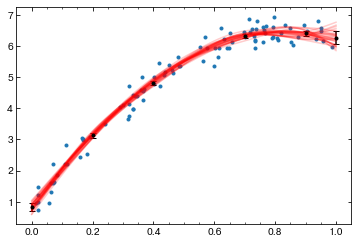

In [7]:
plt.plot(x, y, '.')
nplot = 30
xgrid = np.linspace(0, 1, 1000)
plt.errorbar(xknots,
             res['yknots'].mean(axis=0),
             res['yknots'].std(axis=0),
             fmt='.',
             color='black')
for i in range(nplot):
    C = scipy.interpolate.CubicSpline(xknots,
                                      res['yknots'][i],
                                      bc_type='natural')
    plt.plot(xgrid, C(xgrid), alpha=0.2, color='red')
